# Klaszterezés és az EM algoritmus

**Emlékeztető.** Tegyük fel, hogy a modellünkben van megfigyelt és rejtett változó is. Ez a modell illesztését nagyon megnehezíti, hiszen

\begin{align}
p(x|\theta) = \int p(x,z|\theta) dz, 
\end{align}

ahol $x$ a megfigyelt változó, $z$ rejtett, $\theta$ a $p$ eloszlás paraméterezése. Azaz nemcsak, hogy $z$ eloszlásáról kell nyilatkoznunk (ez még menne), hanem várható értéket is kell számolni vele; ez az integrál azonban rendszerint nem megoldható. Szerencsére jó közelítés még így is adható. Láttuk, hogy a $p(x|\theta)$ eloszlást a következőképpen dekomponálhatjuk:

\begin{align}
\ln p(x|\theta) = \int q(z) \ln \frac{p(x,z|\theta)}{q(z)} dz - \int q(z) \ln \frac{p(z|x,\theta)}{q(z)} dz = \mathcal{L}[q] + KL(q||p) ,
\end{align}

ahol $\mathcal{L}[q]$ az alsó korlát (ELBO) és $KL(q||p)$ a KL-divergencia. Korábban, a varációs módszereknél olyan $q(z)$-t kerestünk, amelyik KL értelemben jól közelíti a $p(z|x,\theta)$ feltételes eloszlást; ezt úgy értük el, hogy az előbbi egyenletben az ELBO-t maximalizáltuk $q \in \mathcal{Q}$ szerint (innen a "variációs" megnevezés). Mivel a bal oldal fix, ez szükségszerűen a KL-divergencia csökkenését, azaz a közelítés javulását eredményezi. Ehhez igyekeztünk olyan $\mathcal{Q}$ függvényosztályt találni, ami elég tág ahhoz, hogy jó közelítést kapjunk. Tipikusan, $q$-t egy mély neurális hálózat adta (pl. VAE).

Most más megközelítést választunk, megkötjük $q$ alakját. Szerencsére $q$ (adott $\hat \theta$ melletti!) optimális alakját könnyen meghatározhatjuk, hiszen a KL-divergencia akkor minimális, ha

\begin{align}
q(z) := p(z|x,\hat \theta),
\end{align}

ahol $\hat \theta$ azt sugallja, hogy itt $\theta$-nak egyfajta iteratív frissítéséről lesz szó (másképpen, maximum likelihood megoldást keresünk). Behelyettesítve az ELBO-ba, és csak a $\theta$-t tartalmazó tagot megtartva:

\begin{align}
\mathcal{L}[q] &= \int p(z|x,\hat\theta) \ln \frac{p(x,z|\theta)}{p(z|x,\hat\theta)} dz \\
 &= \int p(z|x,\hat\theta) \ln p(x,z|\theta) dz + const. \\
 &= E_{p(z|x,\hat\theta)} \left[\ln p(x,z|\theta) \right] + const.
\end{align}

A következő iteratív sémához jutottunk:
- E-lépés (expectation): $\hat\theta$-t fixen tartva meghatározzuk $q(z) = p(z|x,\hat\theta)$ és az $\mathcal{L}[q]$ várható értéket.
- M-lépés (maximization): $q$-t fixen tartva maximalizáljuk $\mathcal{L}$-t $\theta$ szerint (ő lesz az új $\hat\theta$).

Ez az EM algoritmus lényege. Látjuk, hogy mindkét lépés növeli az ELBO-t, tehát tényleg maximum likelihood megoldást fogunk találni.

**E-lépés Gauss keverék-eloszlásokra.** Legyenek adottak az $\mathbf{x}_i \in \mathbb{R}^d$ alakú adatpontok, és tegyük fel a következő valószínűségi modellt:

\begin{align}
p(z_i | \pi) &= \mathcal{C}at(z_i | \pi) = \prod_k \pi_k^{z_{ik}}, \\
p(\mathbf{x}_i | z_i,\mu,\Sigma) &= \prod_k \mathcal{N}(\mathbf{x}_i | \mu_k,\Sigma_k)^{z_{ik}},
\end{align}

ahol $z_i$ one-hot módon kódolt és $\sum_k \pi_k = 1$. Az ilyen eloszlásokat nevezzük Gauss keverék-eloszlásnak, hiszen

\begin{align}
p(\mathbf{x}_i | \mu,\Sigma,\pi) = \sum_{z_i} p(\mathbf{x}_i | z_i,\mu,\Sigma) p(z_i | \pi) = \sum_k \pi_k \mathcal{N}(\mathbf{x}_i | \mu_k,\Sigma_k) .
\end{align}

Ezzel lényegében azt mondjuk, hogy minden $\mathbf{x}_i$ adatpont a $K$ darab Gauss-eloszlás valamelyikéből jön. A keverék-eloszlás komponensei felelnek meg a klasztereknek, és minden klaszternek van egy $\mu_k$ várható értéke és egy $\Sigma_k$ kovarianciamátrixa. A célunk, hogy megtaláljuk a klaszterek középpontjait és "kiterjedését", azaz maximum likelihood becslést fogunk végezni a $\pi$, $\mu$, $\Sigma$ paraméterekre az EM algoritmussal. Kiszámítjuk az ehhez szükséges mennyiségeket az összes adatpontra ($\theta$ most értelemszerűen három paraméterre bomlik):

\begin{align}
\ln p(\mathbf{X},\mathbf{Z} | \pi,\mu,\Sigma) &= \sum_i \ln p(\mathbf{x}_i | z_i,\mu,\Sigma) + \ln p(z_i | \pi) = \sum_i \sum_k z_{ik} \left( \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k ) \right) , \\
p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma) &\propto p(\mathbf{X} | \mathbf{Z}, \mu,\Sigma) p(\mathbf{Z} | \pi) = \prod_i \prod_k \pi_k^{z_{ik}}\mathcal{N}(\mathbf{x}_i | \mu_k,\Sigma_k)^{z_{ik}}.
\end{align}

Majd kiszámítjuk az EM algoritmusban használt várható értéket:

\begin{align}
E_{p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma)} \left[ \ln p(\mathbf{X},\mathbf{Z} | \pi,\mu,\Sigma) \right] &= \sum_i \sum_k E_{p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma)}\left[z_{ik}\right] \left( \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k ) \right) \\
E_{p(\mathbf{Z} | \mathbf{X}, \pi,\mu,\Sigma)}\left[z_{ik}\right] &= \sum_{z_{ik}} z_{ik} p(z_{ik} | \mathbf{x}_i, \pi_k,\mu_k,\Sigma_k) \\
&= \sum_{z_{ik}} z_{ik} \frac{p(\mathbf{x}_i | z_{ik}, \mu_k, \Sigma_k) p(z_{ik} | \pi_k)}{p(\mathbf{x}_i | \mu, \Sigma,\pi)} \\
&= \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)}{\sum_k \pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)} =: \gamma_{ik} .
\end{align}

Ha jobban megnézzük, utóbbinak szemléletes jelentése is van: a $k$. klaszter mennyiben "felelős" az $\mathbf{x}_i$ pontért (intuitíve: a beletartozások valószínűségeinek arányában). Összesítve az ELBO:

\begin{align}
\mathcal{L} (\pi,\mu,\Sigma) = \sum_i \sum_k \gamma_{ik} \left( \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k ) \right) .
\end{align}

**M-lépés Gauss keverék-eloszlásokra.** Az M lépésben rögzítjük $\gamma_{ik}$-t, és maximalizáljuk az ELBO-t $\pi$, $\mu$ és $\Sigma$ szerint. Vegyük először $\mu_k$ szerint:

\begin{align}
\nabla_{\mu_k} \mathcal{L} &= -\sum_i \gamma_{ik} \Sigma_k^{-1} (\mathbf{x}_i-\mu_k) = 0 \\
&\Rightarrow \mu_k = \frac{1}{N_k} \sum_i \gamma_{ik} \mathbf{x}_i ,\quad N_k = \sum_i \gamma_{ik}
\end{align}

ahol szintén találunk szemléletes jelentést: $\mu_k$ a $k$. klaszterbe tartozó pontok súlyozott átlaga, ahol a "beletartozás" mértéke adja a súlyt. Hasonlóképpen $\Sigma_k$-ra

\begin{align}
\Sigma_k = \frac{1}{N_k} \sum_i \gamma_{ik} (\mathbf{x}_i-\mu_k)(\mathbf{x}_i-\mu_k)^T
\end{align}

adódik. Végül $\pi_k$-ra

\begin{align}
\max_{\pi_k} &\quad \sum_i \gamma_{ik} \ln \pi_k \\
s.t. &\quad \sum_k \pi_k = 1,
\end{align}

ahol a Lagrange-dualitást felhasználva

\begin{align}
L(\pi_k,\mu) &= \sum_i \gamma_{ik} \ln \pi_k + \mu \left(\sum_k \pi_k - 1 \right), \\
\frac{\partial L}{\partial \pi_k} &= \frac{N_k}{\pi_k} + \mu = 0, \\
 &\Rightarrow \pi_k = - \frac{N_k}{\mu}.
\end{align}

Utóbbit $k$ szerint szummázva

\begin{align}
1 = \frac{-\sum_k {N_k}}{\mu} \Rightarrow \mu = - \sum_k N_k = - N \Rightarrow \pi_k = \frac{N_k}{N},
\end{align}

ahol $N$ egyben a mintahalmaz mérete.

**Összefoglalás.** Az EM algoritmus Gauss keverék eloszlásokra a következő:

0. Inicializáció véletlen $\mu$, $\Sigma$ és $\pi$ paraméterekkel.
1. E-lépés: $\gamma_{ik} = \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)}{\sum_k \pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)}$, $N_k = \sum_i \gamma_{ik}$.
2. M-lépés: $\mu_k = \frac{1}{N_k} \sum_i \gamma_{ik} \mathbf{x}_i$, $\Sigma_k = \frac{1}{N_k} \sum_i \gamma_{ik} (\mathbf{x}_i-\mu_k)(\mathbf{x}_i-\mu_k)^T$, $\pi_k = \frac{N_k}{N}$.
3. Ismétlés.

In [3]:
%pylab inline

from scipy.stats import multivariate_normal

Populating the interactive namespace from numpy and matplotlib


**0. feladat.** A lenti kóddal generáljon és ábrázoljon egy adathalmazt.

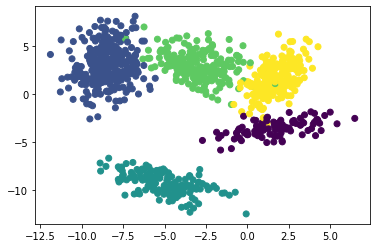

In [6]:
def generate_data(N,K):
  mu,sg = [],[]
  for k in range(K):
    mu += [np.random.randn(2)*5]
    ss = np.random.randn(2,2)
    sg += [ss.T@ss + np.eye(2)/2]

  pi = np.random.rand(K)
  pi = pi/sum(pi)
  X,Z = [],[]
  for i in range(N):
    k = np.random.choice(np.arange(K),p=pi)
    X += [multivariate_normal.rvs(mu[k],sg[k])]
    Z += [k]
  X = np.row_stack(X)
  return X,Z,np.vstack(mu),sg,pi

X,Z_,mu_,sg_,pi_ = generate_data(1000,5)
scatter(X[:,0],X[:,1],c=Z_)

**1. feladat.** Implementálja a fenti algoritmust! Törekedjen az egyszerűségre, a feladat kb. 15 sorból megoldható. Külső csomagot ne használjon (ez alól a `numpy` és a `multivariate_normal.pdf()` függvény kivétel, ezt érdemes is beépíteni a megoldásba).

In [38]:
def cluster(K, X, ii):
  D = X.shape[1]
  mu = np.random.randn(K, D)
  sigma = [np.eye(D) for k in  range(K)]
  pi = np.ones(K)/K

  for i in range(ii):
    G = np.column_stack([pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k]) for k in range(K)])
    G = G/np.expand_dims(np.sum(G, axis=1), 1)
    N = np.sum(G, axis=0)

    for k in range(K):
      d = X-mu[k]
      sigma[k] = d.T@(d*np.expand_dims(G[:, k], 1)) / N[k]
    
    mu = G.T@X / np.expand_dims(N, 1)

    pi =  N/np.sum(N)


  return mu, sigma, pi

A fenti algoritmus (az előadáson mutatott Julia kód referenciakénti használatával) implementáltam.

**2. feladat.** Ábrázolja a kiakakuló klasztereket! Az ábrán jelenjenek meg a pontok (klaszterenként különböző színekkel), valamint az illesztett komponensek szintvonalai.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'c'


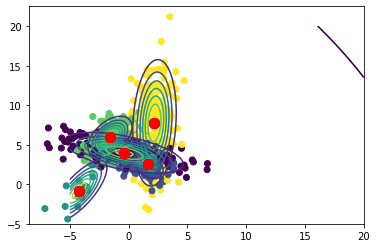

In [61]:
from matplotlib.patches import Ellipse


x1 = np.linspace(-5, 20,1000)  
x2 = np.linspace(-5, 20,1000)
XX, Y = np.meshgrid(x1,x2) 

pos = np.empty(XX.shape + (2,))                
pos[:, :, 0] = XX; pos[:, :, 1] = Y 

X,Z_,mu_,sg_,pi_ = generate_data(1000,5)
scatter(X[:,0],X[:,1],c=Z_, zorder=0);
mu, sigma, pi = cluster(5, X, 1000)

for k in range(5):
  scatter(mu[:,0],mu[:,1],c="red", s=100, zorder=2)
  Z1 = multivariate_normal.pdf(pos, mu[k], sigma[k])
  contour(XX, Y, Z1, c=Z_, zorder=1) 

Ahogy fentebb is látszik, a különb. középpontok és a kontúrok általi szintvonalak kirajzolódnak. 

**3. feladat.** Értékelje ki a megoldást a következők alapján:

- Prediktált és valódi klaszterezés együttjárása (`sklearn.metrics.adjusted_rand_score`)
- Klaszterközéppontok eltérése a valódi klaszterközéppontoktól (plot)

A kiértékelést végezze el több véletlenszerűen generált adathalmazon is. Mit tapasztalt?

In [36]:
 from sklearn.metrics.cluster import adjusted_rand_score


for iter in range(10):
  X2,Z_2,mu_2,sg_2,pi_2 = generate_data(1000,5)
  Z2, mu2, sigma2, pi2 = cluster(5, X2, 1000)
  print("Score: " + str(adjusted_rand_score(Z_2, Z2)))
  for iter2 in range(5):
    dist = sqrt( (mu_2[iter2][0] - mu2[iter2][0])**2 + (mu_2[iter2][1] - mu2[iter2][1])**2 )
    print("Dist No. " + str(iter2) + " " + str(dist))


Score: 0.9541791158501538
Dist No. 0 13.991555272948322
Dist No. 1 0.0370971590100981
Dist No. 2 11.485629917273789
Dist No. 3 4.9132073044710545
Dist No. 4 0.18954953084585172
Score: 0.4822078821912963
Dist No. 0 0.21453300858337077
Dist No. 1 11.812390421728805
Dist No. 2 12.61629256662595
Dist No. 3 6.012491128505445
Dist No. 4 6.230541778495131
Score: 0.8496796137168755
Dist No. 0 0.26089787156624183
Dist No. 1 6.194554982956018
Dist No. 2 0.3658280147405835
Dist No. 3 8.148614457199987
Dist No. 4 15.826719473844996
Score: 0.9604751455708893
Dist No. 0 0.06356900851347232
Dist No. 1 7.577709242449919
Dist No. 2 16.122032300954658
Dist No. 3 6.629285760899014
Dist No. 4 16.01510269416327
Score: 0.5191541636646033
Dist No. 0 4.686776321428687
Dist No. 1 10.20862162650478
Dist No. 2 5.5823682654937095
Dist No. 3 8.60285841378972
Dist No. 4 8.71828052449594
Score: 0.9644779200520711
Dist No. 0 23.00862767052596
Dist No. 1 0.6073114251179116
Dist No. 2 23.219540109754174
Dist No. 3 2.89

Fentebb 10 darab véletlenszerűen generált adathalmazra néztem meg az adjusted_rand_score-t, illetve a középpontok tényleges és predikált távolságát. Előbbin látszik, hogy erősen esetfüggő, tekintve, hogy a score maga 0.51 és 0.96 közt mozog. Utóbbiről is hasonló mondható el, hiszen egészen elenyésző távolságoktól (0.0__) egészen 16.__-os nagyobb távolságokat is felfedezhetünk.